In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import pulp

from typing import Optional, List,Tuple,Dict,Any
from dataclasses import dataclass,field
from queue import PriorityQueue

# Phone Ranking Problem using UTA and AHP

Łukasz Andryszewski 151930

Choosing a new phone is often quite a daunting task, with many different models from different companies and varying prices.

In [2]:
data = pd.read_csv("./data/dataset.csv")
prefs = pd.read_csv("./data/preferences.csv")

In [3]:
data

,name,price-cost,ram-gain,screen-gain,disk-gain,oled-gain,os-gain,foldable-gain
0,Huawei P30,1699,6.000,6.10,128,1,3,0
1,Huawei P20 Lite,899,4.000,5.80,64,0,3,0
2,Iphone 15,4699,6.000,6.70,128,1,0,0
3,Iphone 12,2499,4.000,6.10,64,1,0,0
4,Motorola Razr Ultra,3999,8.000,6.90,256,1,3,1
5,Motorola Razr 40,2999,8.000,6.90,256,1,3,1
6,Samsung Galaxy Z Flip 5,5599,8.000,6.70,256,1,3,1
7,Motorola Razr 8,2657,8.000,6.67,256,1,3,1
8,Nokia 2660 Flip,299,4.000,2.80,128,1,1,1
9,Huawei P40,1949,8.000,6.10,128,1,2,0


In [4]:
crit_types = [True if crit.split("-")[1]=="gain" else False for crit in data.drop(columns="name").columns ]
crit_types

[False, True, True, True, True, True, True]

In [5]:
data.columns = list(map(lambda s: s.split("-")[0],data.columns))
data

,name,price,ram,screen,disk,oled,os,foldable
0,Huawei P30,1699,6.000,6.10,128,1,3,0
1,Huawei P20 Lite,899,4.000,5.80,64,0,3,0
2,Iphone 15,4699,6.000,6.70,128,1,0,0
3,Iphone 12,2499,4.000,6.10,64,1,0,0
4,Motorola Razr Ultra,3999,8.000,6.90,256,1,3,1
5,Motorola Razr 40,2999,8.000,6.90,256,1,3,1
6,Samsung Galaxy Z Flip 5,5599,8.000,6.70,256,1,3,1
7,Motorola Razr 8,2657,8.000,6.67,256,1,3,1
8,Nokia 2660 Flip,299,4.000,2.80,128,1,1,1
9,Huawei P40,1949,8.000,6.10,128,1,2,0


In [6]:
prefs

,id,preferred_to
0,0,1
1,4,6
2,8,11
3,3,2
4,3,9


In [9]:
for i,j in zip(prefs["id"],prefs["preferred_to"]):
	print(i,j)

0 1
4 6
8 11
3 2
3 9


In [11]:
def show_preferences(prefs,names,id_column="id",pref_column = "preferred_to"):
    for i,j in zip(prefs[id_column],prefs[pref_column]):
        print(f"{names[i]} is preferred to {names[j]}")

In [12]:
show_preferences(prefs,data["name"])

Huawei P30 is preferred to Huawei P20 Lite
Motorola Razr Ultra is preferred to Samsung Galaxy Z Flip 5
Nokia 2660 Flip is preferred to Nokia 3310
Iphone 12 is preferred to Iphone 15
Iphone 12 is preferred to Huawei P40


In [257]:
@dataclass(order=True)
class BreakPoint:
	x: float
	y: float=field(compare=False)

	def __getitem__(self,key):
		if key == 0:
			return self.x
		elif key == 1:
			return self.y
		else:
			raise IndexError("Not a valid key '{}'".format(key))


class ValueFunction:
	def __init__(self,*args):
		self.breakpoints = []
		for (i,j) in args:
			self.breakpoints.append(BreakPoint(i,j))
		
		self.breakpoints.sort()

	def __call__(self, *args: Any, **kwds: Any) -> Any:
		x = args[0]
		previous_breakpoint = None
		for breakpoint in self.breakpoints:
			if (x <= breakpoint.x): 
				break
			previous_breakpoint = breakpoint

		x2,y2 = breakpoint
		if previous_breakpoint != None:
			x1,y1 = previous_breakpoint

		if previous_breakpoint != None and previous_breakpoint != breakpoint:
			return (((x-x1)/(x2-x1)) * (y2-y1)) + y1 
		else: 
			return y2
	
	def __iadd__(self,xy):
		x,y = xy
		self.breakpoints.append(BreakPoint(x,y))
		self.breakpoints.sort()
		return self

	def plot(self):
		# x1,y1 = self.breakpoints[0]
		# x2,y2 = self.breakpoints[-1]
		# x = np.arange(x1,x2+1,1)
		# y = [self(x_i) for x_i in x]
		x = [breakpoint.x for breakpoint in self.breakpoints]
		y = [breakpoint.y for breakpoint in self.breakpoints]
		plt.plot(x,y)
		plt.show()

class AdditiveValueFunction:
	def __init__(self,weights:np.array,u_funcs:List[ValueFunction]):
		self.u_funcs = u_funcs
		self.weights = weights
		self.__weight_sum = np.sum(weights)

	def __call__(self,*alt,**kwds):
		values = np.array([self.u_funcs[i](crit) for i,crit in enumerate(alt)])
		return sum((self.weights*values)/self.__weight_sum)



In [200]:
U = ValueFunction((0,0),(2,4),(3,5),(4,7),(5,10),(7,12))

In [201]:
U += (1,0.5)

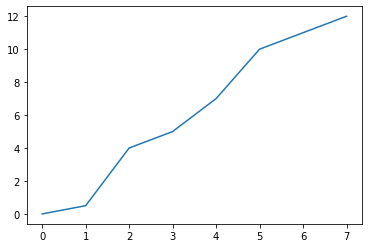

In [202]:
U.plot()

In [258]:
def basic_U(data:pd.DataFrame,crit_types:List[bool],weights:np.array=None):
	u_max = 1/len(data.columns)
	u_funcs = []
	if weights == None:
		weights = [1] * len(data.columns)
	for crit_i,column_name in enumerate(data):
		column = data[column_name]
		_min = min(column)
		_max = max(column)
		best,worst = _max,_min
		if not crit_types[crit_i]:
			best,worst = worst,best
		u_funcs.append(ValueFunction((worst,0),(best,u_max)))
		
	return AdditiveValueFunction(weights,u_funcs)

In [259]:
U = basic_U(data.drop(columns="name"),crit_types)

In [303]:
def minimal_subset(data:pd.DataFrame,prefs:pd.DataFrame,U:AdditiveValueFunction,equals:pd.DataFrame=None):
	problem = pulp.LpProblem("minimal_subset")

	variables = dict([((i,j),pulp.LpVariable(f"v_{i}_{j}",cat=pulp.LpBinary)) for i,j in zip(prefs["id"],prefs["preferred_to"])])
	
	# objective function
	problem += pulp.lpSum([var for var in variables.values()])

	# preferences
	for (i,j),var in variables.items():
		alt_i,alt_j = data.iloc[i],data.iloc[j]
		problem += (U(*alt_j) - var <= U(*alt_i))

	return problem

In [304]:
problem = minimal_subset(data.drop(columns="name"),prefs,U)
problem

minimal_subset:
MINIMIZE
1*v_0_1 + 1*v_3_2 + 1*v_3_9 + 1*v_4_6 + 1*v_8_11 + 0
SUBJECT TO
_C1: - v_0_1 <= 0.0246523634685

_C2: - v_4_6 <= 0.00672292921533

_C3: - v_8_11 <= 0.0558013786178

_C4: - v_3_2 <= -0.000225844361179

_C5: - v_3_9 <= -0.0250849304357

VARIABLES
0 <= v_0_1 <= 1 Integer
0 <= v_3_2 <= 1 Integer
0 <= v_3_9 <= 1 Integer
0 <= v_4_6 <= 1 Integer
0 <= v_8_11 <= 1 Integer

In [305]:
problem.solve()
print("Status:", pulp.LpStatus[problem.status])
print("Optimal Solution:")
for v in problem.variables():
    print(v.name, "=", v.varValue)
print("Optimal Objective Value:", pulp.value(problem.objective))

Status: Optimal
Optimal Solution:
v_0_1 = 0.0
v_3_2 = 1.0
v_3_9 = 1.0
v_4_6 = 0.0
v_8_11 = 0.0
Optimal Objective Value: 2.0


In [ ]:
def ordinal_regression(data:pd.DataFrame,prefs:pd.DataFrame,U:AdditiveValueFunction):
	problem = pulp.LpProblem("ordinal_regression")

	variables = dict([((i,j),pulp.LpVariable(f"v_{i}_{j}",cat=pulp.LpBinary)) for i,j in zip(prefs["id"],prefs["preferred_to"])])
	
	# objective function
	problem += pulp.lpSum([var for var in variables.values()])

	# preferences
	for (i,j),var in variables.items():
		alt_i,alt_j = data.iloc[i],data.iloc[j]
		problem += (U(*alt_j) - var <= U(*alt_i))

	return problem